# Neuropixel Spiking and LFP analysis

- [Original Article](https://www.nature.com/articles/s41586-019-1787-x)
- [Neuromatch Notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/neurons/load_steinmetz_decisions.ipynb#scrollTo=J4a1U2AnrDb_)
- [Dataset](https://uni-bonn.sciebo.de/s/Z66tPbIFGGSA3FD)

## Import

In [1]:
import numpy as np
import scipy.signal as sig
import netCDF4 as nc
import matplotlib.pyplot as plt
from pathlib import Path
import os
import scipy.stats as stats
import fooof
import scipy
from fooof import FOOOF
from fooof import FOOOFGroup

## Load data

In [2]:
# create path for sourcedata steinmetz using pathlib
source_path = Path(os.getcwd()).parent / "sourcedata"
data_path = os.path.join(source_path, "steinmetz_2016-12-14_Cori.nc")
data = nc.Dataset(data_path)

## Extract LFP

In [3]:
brain_area = "MOs"
brain_area_lfp_idx = np.where(data.variables["brain_area_lfp"][:] == brain_area)[0][0]
area_lfp = data.variables["lfp"][brain_area_lfp_idx].data

## Extract spiking

In [4]:
brain_area = "MOs"
brain_area_spike_idx = np.where(data.variables["brain_area"][:] == brain_area)[0]
brain_area_spike_idx
area_spiking = data.variables["spike_rate"][brain_area_spike_idx].data

spiking_activity = np.mean(area_spiking, axis=0)

In [5]:
assert area_lfp.shape == spiking_activity.shape, "Shapes don't match"

## Correlate mean trial PSD with trial spiking activity

In [ ]:
sample_rate = 100
freqs, pwr = sig.welch(area_lfp, fs=sample_rate, nperseg=sample_rate // 2)
# freqs, pwr = sig.welch(area_lfp, fs=1000)

mean_psd = np.mean(pwr, axis=1)
mean_psd.shape

mean_spiking_activity = np.sum(spiking_activity, axis=1)
mean_spiking_activity.shape

(364,)

In [ ]:
rho, pval = stats.spearmanr(mean_psd, mean_spiking_activity)

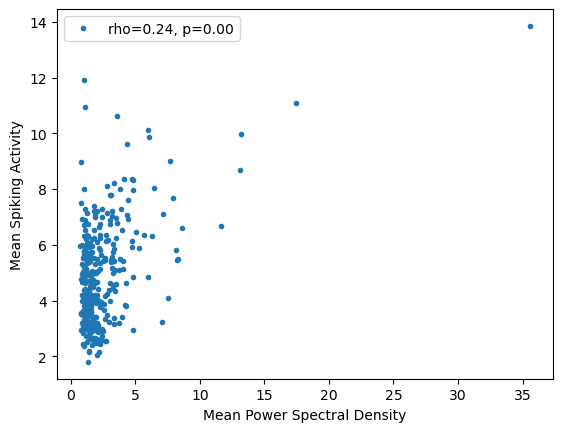

In [ ]:
plt.plot(mean_psd, mean_spiking_activity, ".", label=f"rho={rho:.2f}, p={pval:.2f}")
plt.xlabel("Mean Power Spectral Density")
plt.ylabel("Mean Spiking Activity")
plt.legend()

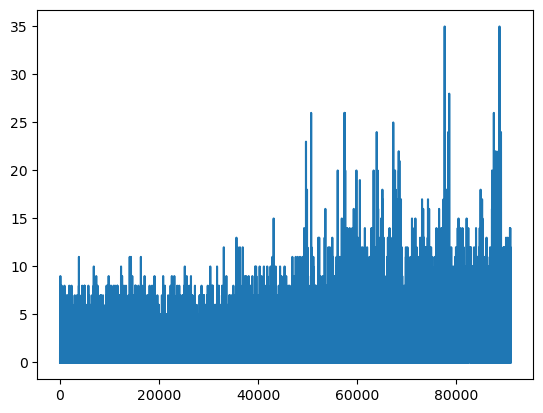

In [6]:
plt.plot(np.hstack(area_spiking.sum(0)))

In [7]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    session_date: 2016-12-14
    mouse: Cori
    stim_onset: 0.5
    bin_size: 0.01
    dimensions(sizes): trial(364), time(250), cell(734), waveform_component(3), sample(82), probe(384), brain_area_lfp(7), spike_id(2446173)
    variables(dimensions): int32 trial(trial), int8 contrast_left(trial), int8 contrast_right(trial), float64 gocue(trial), float64 stim_onset(trial), float64 feedback_type(trial), float64 feedback_time(trial), float64 response_type(trial), float64 response_time(trial), float64 reaction_type(trial), float64 reaction_time(trial), float64 prev_reward(trial), int8 active_trials(trial), float64 time(time), int8 wheel(trial, time), int8 licks(trial, time), float64 pupil_x(trial, time), float64 pupil_y(trial, time), float64 pupil_area(trial, time), float64 face(trial, time), int32 cell(cell), int8 spike_rate(cell, trial, time), int8 trough_to_peak(cell), float64 ccf_ap(cell), float64 cc

In [ ]:
data.variables.keys()

dict_keys(['trial', 'contrast_left', 'contrast_right', 'gocue', 'stim_onset', 'feedback_type', 'feedback_time', 'response_type', 'response_time', 'reaction_type', 'reaction_time', 'prev_reward', 'active_trials', 'time', 'wheel', 'licks', 'pupil_x', 'pupil_y', 'pupil_area', 'face', 'cell', 'spike_rate', 'trough_to_peak', 'ccf_ap', 'ccf_dv', 'ccf_lr', 'brain_area', 'brain_groups', 'waveform_component', 'waveform_w', 'probe', 'waveform_u', 'brain_area_lfp', 'lfp', 'spike_id', 'spike_time', 'spike_cell', 'spike_trial'])

In [ ]:
data.dimensions["sample"]

TypeError: 'netCDF4._netCDF4.Dimension' object is not subscriptable

In [9]:
data.variables["time"][:].data

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.

In [10]:
data.variables["spike_rate"][:].data

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [11]:
data.variables["spike_rate"][:].data.shape

(734, 364, 250)

In [12]:
data.variables["brain_area"][:]

array(['ACA', 'MOs', 'ACA', 'LS', 'MOs', 'ACA', 'root', 'MOs', 'MOs',
       'LS', 'LS', 'LS', 'MOs', 'LS', 'LS', 'LS', 'ACA', 'MOs', 'ACA',
       'MOs', 'ACA', 'LS', 'MOs', 'MOs', 'ACA', 'MOs', 'MOs', 'MOs', 'LS',
       'MOs', 'MOs', 'ACA', 'MOs', 'MOs', 'MOs', 'LS', 'ACA', 'LS', 'MOs',
       'ACA', 'LS', 'LS', 'ACA', 'ACA', 'LS', 'LS', 'ACA', 'ACA', 'LS',
       'MOs', 'MOs', 'ACA', 'MOs', 'MOs', 'LS', 'MOs', 'MOs', 'ACA',
       'ACA', 'LS', 'MOs', 'ACA', 'LS', 'LS', 'MOs', 'MOs', 'LS', 'LS',
       'LS', 'ACA', 'MOs', 'MOs', 'LS', 'ACA', 'ACA', 'LS', 'LS', 'ACA',
       'LS', 'MOs', 'ACA', 'LS', 'ACA', 'LS', 'MOs', 'MOs', 'MOs', 'LS',
       'MOs', 'LS', 'ACA', 'ACA', 'ACA', 'MOs', 'LS', 'ACA', 'ACA', 'LS',
       'ACA', 'LS', 'MOs', 'MOs', 'MOs', 'ACA', 'LS', 'ACA', 'ACA', 'MOs',
       'root', 'MOs', 'MOs', 'MOs', 'LS', 'MOs', 'LS', 'ACA', 'ACA',
       'ACA', 'LS', 'LS', 'ACA', 'MOs', 'LS', 'MOs', 'ACA', 'ACA', 'ACA',
       'MOs', 'ACA', 'ACA', 'MOs', 'ACA', 'MOs', 'LS', 'LS

In [13]:
data.variables["brain_area"][:]

array(['ACA', 'MOs', 'ACA', 'LS', 'MOs', 'ACA', 'root', 'MOs', 'MOs',
       'LS', 'LS', 'LS', 'MOs', 'LS', 'LS', 'LS', 'ACA', 'MOs', 'ACA',
       'MOs', 'ACA', 'LS', 'MOs', 'MOs', 'ACA', 'MOs', 'MOs', 'MOs', 'LS',
       'MOs', 'MOs', 'ACA', 'MOs', 'MOs', 'MOs', 'LS', 'ACA', 'LS', 'MOs',
       'ACA', 'LS', 'LS', 'ACA', 'ACA', 'LS', 'LS', 'ACA', 'ACA', 'LS',
       'MOs', 'MOs', 'ACA', 'MOs', 'MOs', 'LS', 'MOs', 'MOs', 'ACA',
       'ACA', 'LS', 'MOs', 'ACA', 'LS', 'LS', 'MOs', 'MOs', 'LS', 'LS',
       'LS', 'ACA', 'MOs', 'MOs', 'LS', 'ACA', 'ACA', 'LS', 'LS', 'ACA',
       'LS', 'MOs', 'ACA', 'LS', 'ACA', 'LS', 'MOs', 'MOs', 'MOs', 'LS',
       'MOs', 'LS', 'ACA', 'ACA', 'ACA', 'MOs', 'LS', 'ACA', 'ACA', 'LS',
       'ACA', 'LS', 'MOs', 'MOs', 'MOs', 'ACA', 'LS', 'ACA', 'ACA', 'MOs',
       'root', 'MOs', 'MOs', 'MOs', 'LS', 'MOs', 'LS', 'ACA', 'ACA',
       'ACA', 'LS', 'LS', 'ACA', 'MOs', 'LS', 'MOs', 'ACA', 'ACA', 'ACA',
       'MOs', 'ACA', 'ACA', 'MOs', 'ACA', 'MOs', 'LS', 'LS

In [14]:
data.variables["brain_area"][:].shape

(734,)

In [15]:
data.variables["lfp"][:].data

array([[[-2.85079365e+00, -4.03968254e+00, -4.19523810e+00, ...,
          7.26984127e-01, -2.21746032e+00,  1.09936508e+01],
        [ 9.14263039e+00,  1.14759637e+01,  1.47648526e+01, ...,
          3.03151927e+00,  9.20929705e+00,  7.97596372e+00],
        [ 2.65668934e+00,  4.54557823e+00,  7.65668934e+00, ...,
         -1.79877551e+01, -1.76544218e+01, -1.15433107e+01],
        ...,
        [-3.73741497e+00, -1.10408163e+00, -2.80408163e+00, ...,
          6.68480726e+00,  1.34514739e+01, -9.29705215e-02],
        [-6.76190476e-01, -3.77619048e+00, -8.06507937e+00, ...,
          2.03349206e+01,  1.96126984e+01,  7.19047619e+00],
        [ 3.18326531e+01,  2.46215420e+01,  1.04659864e+01, ...,
         -5.93401361e+00, -1.26451247e+01, -1.59229025e+01]],

       [[ 9.41496599e-01, -4.18367347e-02, -8.50850340e+00, ...,
          4.52482993e+00, -1.68367347e-02,  8.23316327e+00],
        [ 8.85068027e+00,  7.84234694e+00,  7.06734694e+00, ...,
          2.85068027e+00,  1.97568027e

In [16]:
data.variables["spike_time"][:].data

array([0.2676345 , 2.3083346 , 0.85347587, ..., 0.61856014, 2.188634  ,
       2.3993347 ], dtype=float32)

In [17]:
data.variables["lfp"][:].data.shape

(7, 364, 250)

In [18]:
data.variables["brain_area"][:].shape

(734,)

In [19]:
data.variables["brain_area_lfp"][:]

array(['ACA', 'LS', 'MOs', 'CA3', 'DG', 'SUB', 'VISp'], dtype=object)

In [44]:
brain_area = "MOs"
brain_area = "CA3"

In [45]:
np.where(data.variables["brain_area"][:] ==  brain_area)[0]

array([366, 367, 380, 381, 384, 394, 395, 398, 405, 414, 421, 433, 436,
       451, 452, 460, 462, 475, 476, 480, 494, 502, 509, 512, 539, 540,
       541, 547, 550, 558, 564, 592, 594, 596, 597, 603, 612, 614, 615,
       623, 624, 626, 640, 643, 646, 657, 678, 679, 680, 682, 684, 690,
       692, 695, 701, 704, 708, 709, 710, 713, 714, 715, 718, 719, 722,
       723, 724, 727])

In [46]:
brain_area_idx = np.where(data.variables["brain_area"][:] ==  brain_area)[0]
area_lfp = data.variables["lfp"][brain_area_idx].data
area_lfp

IndexError: integer index exceeds dimension size

In [33]:
brain_area_idx

array([2])

In [22]:
trial = 0

In [23]:
area_lfp_trial = area_lfp[trial]
area_lfp_trial

array([ 4.37979592e+00, -3.55020408e+00, -1.47020408e+00, -1.78020408e+00,
        4.19795918e-01,  8.36979592e+00,  2.01297959e+01,  3.14979592e+00,
        6.75979592e+00,  1.50697959e+01,  1.31197959e+01,  6.21979592e+00,
       -2.10204082e-01, -7.90204082e-01, -2.70204082e-01,  4.02979592e+00,
        2.42979592e+00, -9.04020408e+00, -6.80020408e+00, -7.33020408e+00,
       -3.33020408e+00,  5.39795918e-01,  2.09979592e+00,  5.19979592e+00,
        1.43697959e+01,  1.49697959e+01,  3.82979592e+00, -3.04020408e+00,
        6.07979592e+00,  3.49795918e-01, -8.46020408e+00, -1.03602041e+01,
       -1.60002041e+01, -1.63402041e+01, -8.54020408e+00, -7.60020408e+00,
       -4.46020408e+00,  5.89795918e-01,  7.53979592e+00,  4.34979592e+00,
        3.83979592e+00, -2.16020408e+00, -6.36020408e+00, -1.49020408e+00,
        2.81979592e+00, -7.34020408e+00, -9.50020408e+00, -1.08502041e+01,
       -3.58020408e+00,  1.64979592e+00,  3.07979592e+00,  5.38979592e+00,
        1.76297959e+01,  

Text(0, 0.5, 'Voltage (mV)')

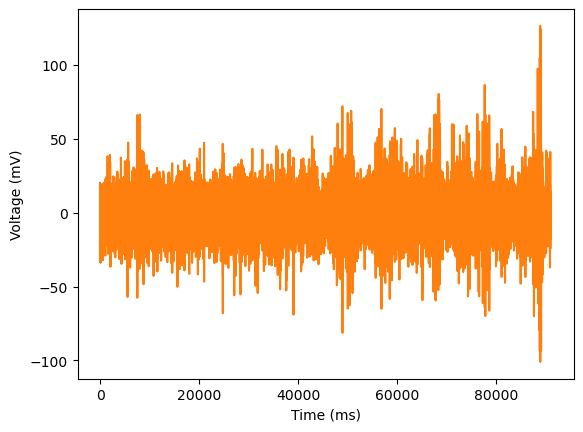

In [24]:
plt.plot(area_lfp_trial)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

plt.plot(np.hstack(area_lfp))
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

In [26]:
spike_rate_area = data.variables["spike_rate"][brain_area_idx].data
spike_rate_area

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [28]:
spike_rate_area.shape

(364, 250)

In [31]:
brain_area_idx

2

In [47]:
spike_times_area = data.variables["spike_time"][brain_area_idx].data
spike_times_area


array([2.24170387e-01, 3.52637053e-01, 9.67402816e-01, 1.76656950e+00,
       2.36143613e+00, 2.39740038e+00, 9.31151211e-01, 4.61453110e-01,
       4.39538121e-01, 3.58543038e-01, 1.93037271e+00, 2.52237432e-02,
       6.25362039e-01, 1.24672890e+00, 9.00452554e-01, 1.27298701e+00,
       1.58745360e+00, 9.13067222e-01, 2.53018469e-01, 1.05376594e-01,
       6.68241322e-01, 8.55815351e-01, 2.01994848e+00, 6.85846090e-01,
       1.86246872e-01, 3.93513560e-01, 6.02480233e-01, 1.69041359e+00,
       1.16982486e-03, 1.85966980e+00, 1.12569976e+00, 1.69269860e+00,
       1.71653199e+00, 2.43529868e+00, 6.76590860e-01, 2.13252425e+00,
       4.31899935e-01, 1.90359998e+00, 2.73417402e-02, 3.15700948e-01,
       6.26900911e-01, 1.59683430e+00, 5.56333326e-02, 8.46300006e-01,
       1.19080520e+00, 1.64452004e+00, 3.46223205e-01, 1.70022321e+00,
       1.49294603e+00, 6.58938050e-01, 1.02340472e+00, 1.80945885e+00,
       1.83769226e+00, 1.86829221e+00, 4.18155551e-01, 1.63792217e+00,
      

In [48]:
spike_times_area.shape

(68,)

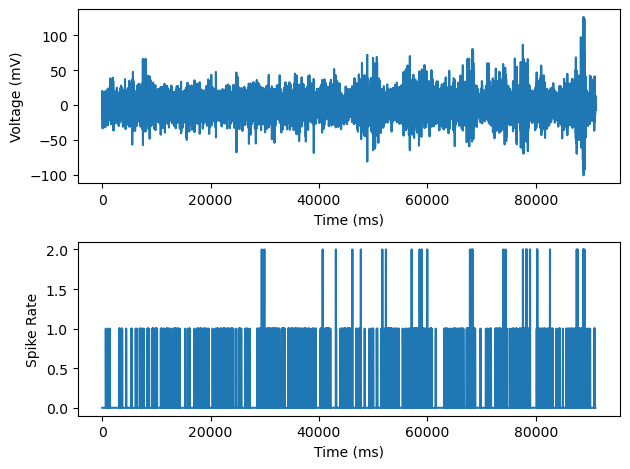

In [27]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.hstack(area_lfp))
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Voltage (mV)")

ax[1].plot(np.hstack(spike_rate_area))
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("Spike Rate")
plt.tight_layout()

In [ ]:
np.hstack(area_lfp).shape

(91000,)

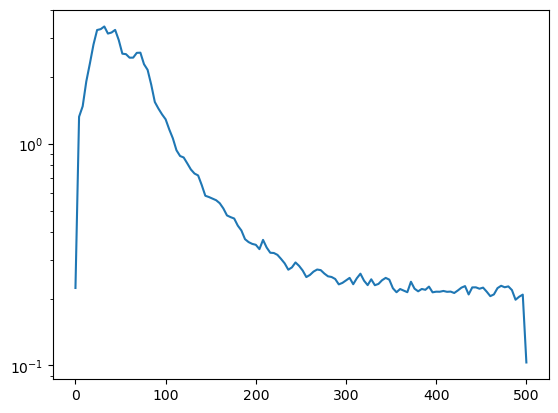

In [ ]:
freqs, pwr = sig.welch(np.hstack(area_lfp), fs=1000, nperseg=1000/4)
plt.semilogy(freqs, pwr)

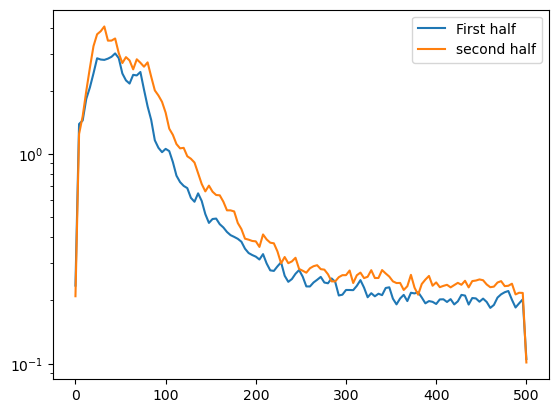

In [ ]:
freqs, pwr = sig.welch(np.hstack(area_lfp)[:50000], fs=1000, nperseg=1000/4)
plt.semilogy(freqs, pwr, label="First half")
freqs, pwr = sig.welch(np.hstack(area_lfp)[50000:], fs=1000, nperseg=1000/4)
plt.semilogy(freqs, pwr, label="second half")
plt.legend()

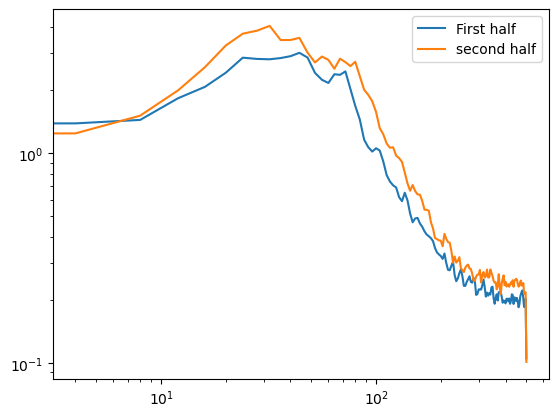

In [ ]:
freqs, pwr = sig.welch(np.hstack(area_lfp)[:50000], fs=1000, nperseg=1000/4)
plt.loglog(freqs, pwr, label="First half")
freqs, pwr = sig.welch(np.hstack(area_lfp)[50000:], fs=1000, nperseg=1000/4)
plt.loglog(freqs, pwr, label="second half")
plt.legend()

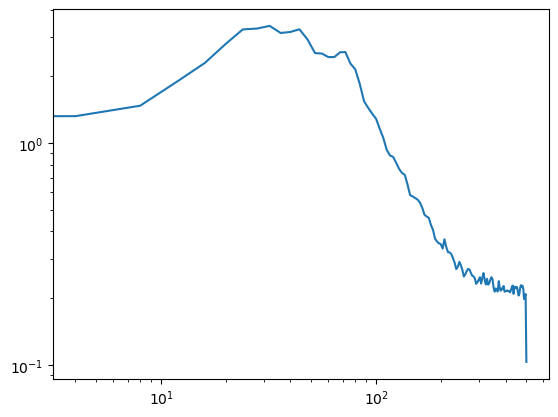

In [ ]:
plt.loglog(freqs, pwr)

In [ ]:
spike_rate_area.shape

(364, 250)

Text(0, 0.5, 'Spike Rate (Hz)')

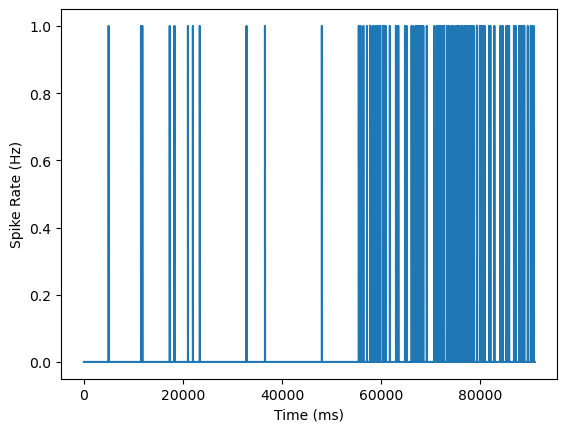

In [ ]:
plt.plot(np.hstack(spike_rate_area))
plt.xlabel("Time (ms)")
plt.ylabel("Spike Rate (Hz)")